### Google Play Store Apps
### Web scraped data of 10k Play Store apps for analysing the Android market.

The data to be utilized for predicting if an app will have a high rating or low rating on Google AI Platform.

In [1]:
import numpy as np # linear algebra
import pandas as pd #Dee data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # set plot style
import seaborn as sns; seaborn.set() # set plot style

In [2]:
df_app_data_raw = pd.read_csv('./data/googleplaystore.csv')
# df_app_user_reviews_raw = pd.read_csv('./data/googleplaystore_user_reviews.csv')

## Data Wrangling

#### Drop Duplicates

In [3]:
df = df_app_data_raw.copy()
# df.drop_duplicates(inplace=True)
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']
df_dropped_duplicates = df
df_dropped_duplicates.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


1. Convert app rating to numeric
2. Convert app number of reviews to numeric
3. Convert app sizes to be in MB (megabytes)
4. Convert number of app installs to numeric
5. Convert app price to numeric
6. Get from supported android version as numeric

In [4]:
df = df_dropped_duplicates.copy()
# Convert app rating to numeric
df['Rating'] = pd.to_numeric(df['Rating'])

# Convert app number of reviews to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'])

# Convert app sizes to be in MB (megabytes)
df.loc[df['Size'] == 'Varies with device', ['Size']]  = np.nan
df.loc[df['Size'].str.contains('M') == True, ['Size']] = pd.to_numeric(df['Size'][df['Size'].str.contains('M') == True].str.replace('M', ''))
# Converting Kb to MB
df.loc[df['Size'].str.contains('k') == True, ['Size']] = pd.to_numeric(df['Size'][df['Size'].str.contains('k') == True].str.replace('k', '')) / 10 ** 3
df['Size'] = pd.to_numeric(df['Size'])

#Convert number of app installs to numeric
df['Installs'] = df['Installs'].str.replace(',', '')
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = pd.to_numeric(df['Installs'])

# Convert app price to numeric
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = pd.to_numeric(df['Price'])

# Get from supported android version as numeric
df.loc[df['Android Ver'] == 'Varies with device', ['Android Ver']]  = np.nan
df.loc[df['Android Ver'].str.contains('.') == True, ['Android Ver']] = df['Android Ver'][df['Android Ver'].str.contains('.') == True].str.split('.').str[0]
df['Android_Ver'] = pd.to_numeric(df['Android Ver'])
df.pop('Android Ver')
df['Android_Ver'] = df['Android_Ver'].astype(str)

In [5]:
data = df.copy()
data = data.dropna()

data['Content_Rating'] = data['Content Rating']
data.pop('Content Rating')

data.loc[data['Rating'].astype(float) < 3.5, ['Rating']] = 0
data.loc[data['Rating'].astype(float) >= 3.5, ['Rating']] = 1
data['Rating'] = data['Rating'].astype('int64')

In [6]:
data.describe()

,Rating,Reviews,Size,Installs,Price
count,7023.000000,7.023000e+03,7023.000000,7.023000e+03,7023.000000
mean,0.904457,1.448548e+05,21.763199,4.470532e+06,1.174099
std,0.293985,1.024285e+06,22.729633,2.714532e+07,18.202768
min,0.000000,1.000000e+00,0.008500,1.000000e+00,0.000000
25%,1.000000,8.400000e+01,4.900000,1.000000e+04,0.000000
50%,1.000000,1.545000e+03,13.000000,1.000000e+05,0.000000
75%,1.000000,2.657950e+04,31.000000,1.000000e+06,0.000000
max,1.000000,4.489172e+07,100.000000,1.000000e+09,400.000000


### Normalize our numerical data

In [7]:
from scipy import stats

def normalize_boxcox(data):
  # Copy the strictly positive data to posdata
  posdata = data[data > 0]
  
  # Find the optimal Box-Cox transformation, and verify that λ is positive
  bcdata, lam = stats.boxcox(posdata)
  
  x = np.empty_like(data)
  x[data > 0] = bcdata
  x[data == 0] = -1/lam
  return x

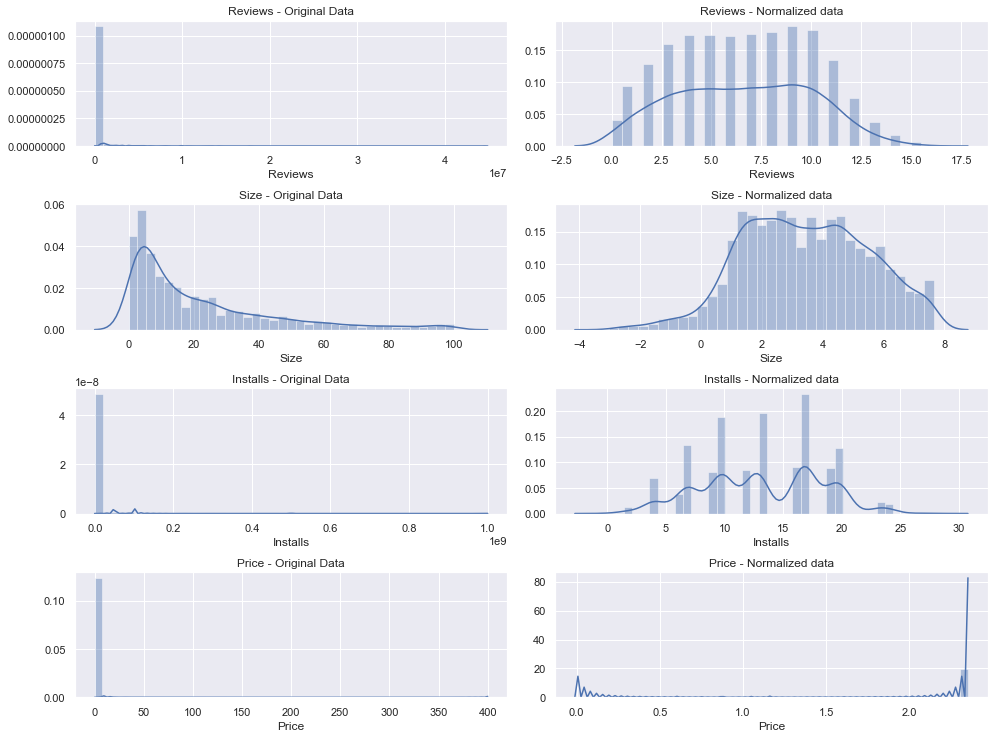

In [8]:
df_normalized = data.copy()

cols = [
  'Reviews',
  'Size',
  'Installs',
  'Price',
]
i = 1
plt.figure(figsize=(15,8))
for col in cols:
  df_normalized[col] = normalize_boxcox(df_normalized[col].values)

  # plot both together to compare
  ax = plt.subplot(6, 2, i)
  ax.figure.set_size_inches(14,15)
  
  sns.distplot(data[col], ax=ax)
  ax.set_title(col + " - Original Data")
  
  i += 1
  ax = plt.subplot(6, 2, i)
  sns.distplot(df_normalized[col], ax=ax)
  ax.set_title(col + " - Normalized data")
  i += 1

plt.tight_layout()
plt.show()

### Split the data into training and testing sets

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_normalized, random_state=0, test_size=0.3)
train.to_csv('./data/train.csv',index=False)
test.to_csv('./data/test.csv',index=False)

In [13]:
test.iloc[0].to_dict()

{'App': 'CA Speakers Free',
 'Category': 'LIFESTYLE',
 'Rating': 1,
 'Reviews': 4,
 'Size': 1.1900410784054827,
 'Installs': 9,
 'Type': 'Free',
 'Price': 2.35152865360602,
 'Genres': 'Lifestyle',
 'Last Updated': 'September 30, 2015',
 'Current Ver': '1.6',
 'Android_Ver': '2.0',
 'Content_Rating': 'Teen'}